# EDA Project Code

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import datetime
from sqlalchemy import create_engine

%matplotlib inline

Establish a connection to SQLite and store the table in Pandas DataFrames

In [2]:
engine = create_engine("sqlite:///data/mta_ts_2021.db")

ts_2021_df = pd.read_sql('select * from mta_ts_2021', con=engine)

Select subway stations located in Manhattan

In [3]:
station_list = ['PRINCE ST', '8 ST-NYU', '1 AV', '33 ST', '28 ST', '42 ST-BRYANT PK', '47-50 STS ROCK', '50 ST', '5 AV/53 ST',
               '57 ST', '72 ST', '77 ST', '86 ST', '34 ST-HUSON YD', '96 ST', '103 ST', 'TIMES SQ-42 ST']

Filter DataFrame by the list of stations in Manhattan

In [138]:
ts_manhattan_2021_df = ts_2021_df[ts_2021_df['STATION'].isin(station_list)].reset_index(drop=True)

Drop duplicates (if present)

In [139]:
ts_manhattan_2021_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE"], inplace=True)

Convert date column from object to datetime

In [140]:
ts_manhattan_2021_df["DATE"] = pd.to_datetime(ts_manhattan_2021_df.DATE, format="%m/%d/%Y")

Remove days from 2020

In [141]:
ts_manhattan_2021_df[ts_manhattan_2021_df['DATE'] > pd.to_datetime('12/31/2020', format="%m/%d/%Y")].reset_index(drop=True)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2021-01-01,03:00:00,REGULAR,9857895,12321630
1,A021,R032,01-00-01,TIMES SQ-42 ST,ACENQRS1237W,BMT,2021-01-01,03:00:00,REGULAR,4112332,4799983
2,A021,R032,01-00-02,TIMES SQ-42 ST,ACENQRS1237W,BMT,2021-01-01,03:00:00,REGULAR,2888416,2811425
3,A021,R032,01-00-03,TIMES SQ-42 ST,ACENQRS1237W,BMT,2021-01-01,03:00:00,REGULAR,2857179,1350123
4,A021,R032,01-00-04,TIMES SQ-42 ST,ACENQRS1237W,BMT,2021-01-01,03:00:00,REGULAR,2560656,3772165
...,...,...,...,...,...,...,...,...,...,...,...
125352,R252,R180,00-03-02,103 ST,6,IRT,2021-10-04,01:00:00,REGULAR,26257114,44997685
125353,R252,R180,00-03-02,103 ST,6,IRT,2021-10-05,01:00:00,REGULAR,26258342,44999297
125354,R252,R180,00-03-02,103 ST,6,IRT,2021-10-06,01:00:00,REGULAR,26259678,45000992
125355,R252,R180,00-03-02,103 ST,6,IRT,2021-10-07,01:00:00,REGULAR,26260792,45002789


 Entries and exits of each turnstile in each station per day

In [142]:
ts_daily_traffic = (ts_manhattan_2021_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"], as_index=False)[['ENTRIES', 'EXITS']].first())

Create "PREV_DATE", "PREV_ENTRIES", and "PREV_EXITS" columns and fill them with the previous values of "DATE", "ENTRIES", and "EXITS"

In [143]:
ts_daily_traffic[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (ts_daily_traffic.groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES", "EXITS"]].apply(lambda grp: grp.shift(1)))
ts_daily_traffic.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

This function is used to calculate the daily entries and exits

In [144]:
def get_daily_counts(row, max_counter, traffic_type):
    counter = row[traffic_type] - row[f"PREV_{traffic_type}"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row[traffic_type], row[f"PREV_{traffic_type}"])
    if counter > max_counter:
        return 0
    return counter

In [153]:
ts_daily_traffic["DAILY_ENTRIES"] = ts_daily_traffic.apply(get_daily_counts, axis=1, max_counter=50000, traffic_type='ENTRIES')
ts_daily_traffic["DAILY_EXITS"] = ts_daily_traffic.apply(get_daily_counts, axis=1, max_counter=50000, traffic_type='EXITS')

In [160]:
stn_daily_traffic = ts_daily_traffic.groupby(["STATION", "DATE"])[["DAILY_ENTRIES", "DAILY_EXITS"]].sum().reset_index()

This function finds anomalies in the passed Series and returns the index of each anomaly in a list

In [161]:
def find_anomalies(data):
    anomalies = []
    
    data_mean = data.mean()
    anomaly_cut_off = data.std() * 3
    lower_lim = data_mean - anomaly_cut_off
    upper_lim = data_mean + anomaly_cut_off
    
    for index, value in enumerate(data):
        if value > upper_lim or value < lower_lim:
            anomalies.append(index)
    
    return anomalies

Drop the anomalies from the DataFrame using the above function

In [162]:
stn_daily_traffic = stn_daily_traffic.drop(index=find_anomalies(stn_daily_traffic['DAILY_ENTRIES']), errors='ignore')
stn_daily_traffic = stn_daily_traffic.drop(index=find_anomalies(stn_daily_traffic['DAILY_EXITS']), errors='ignore')

Create "DAILY_TRAFFIC" column which is the sum of "DAILY_ENTRIES" and "DAILY_EXITS"

In [163]:
stn_daily_traffic['DAILY_TRAFFIC'] = stn_daily_traffic[['DAILY_ENTRIES', 'DAILY_EXITS']].sum(axis=1)

Create "DAY" column and fill with the day of the week depending on the date

In [164]:
def day_of_week(date):
    day = date.dayofweek
    week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    return week[day]

In [166]:
def is_weekday(date):
    return date.dayofweek < 6

In [167]:
stn_daily_traffic['DAY'] = stn_daily_traffic['DATE'].apply(day_of_week)
stn_daily_traffic['WEEKDAY'] = stn_daily_traffic['DATE'].apply(is_weekday)

In [168]:
stn_daily_traffic

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TRAFFIC,DAY,WEEKDAY
0,1 AV,2020-12-20,3926.0,6222.0,10148.0,Sunday,False
1,1 AV,2020-12-21,2838.0,4594.0,7432.0,Monday,True
2,1 AV,2020-12-22,5548.0,8404.0,13952.0,Tuesday,True
3,1 AV,2020-12-23,5583.0,8446.0,14029.0,Wednesday,True
4,1 AV,2020-12-24,5226.0,8335.0,13561.0,Thursday,True
...,...,...,...,...,...,...,...
4682,TIMES SQ-42 ST,2021-10-03,24175.0,38256.0,62431.0,Sunday,False
4683,TIMES SQ-42 ST,2021-10-04,19363.0,29433.0,48796.0,Monday,True
4684,TIMES SQ-42 ST,2021-10-05,29129.0,39034.0,68163.0,Tuesday,True
4685,TIMES SQ-42 ST,2021-10-06,32404.0,43439.0,75843.0,Wednesday,True


Total traffic per station throughout 2021

In [169]:
stn_total = stn_daily_traffic.groupby('STATION')[['DAILY_ENTRIES', 'DAILY_EXITS', 'DAILY_TRAFFIC']].sum().reset_index()

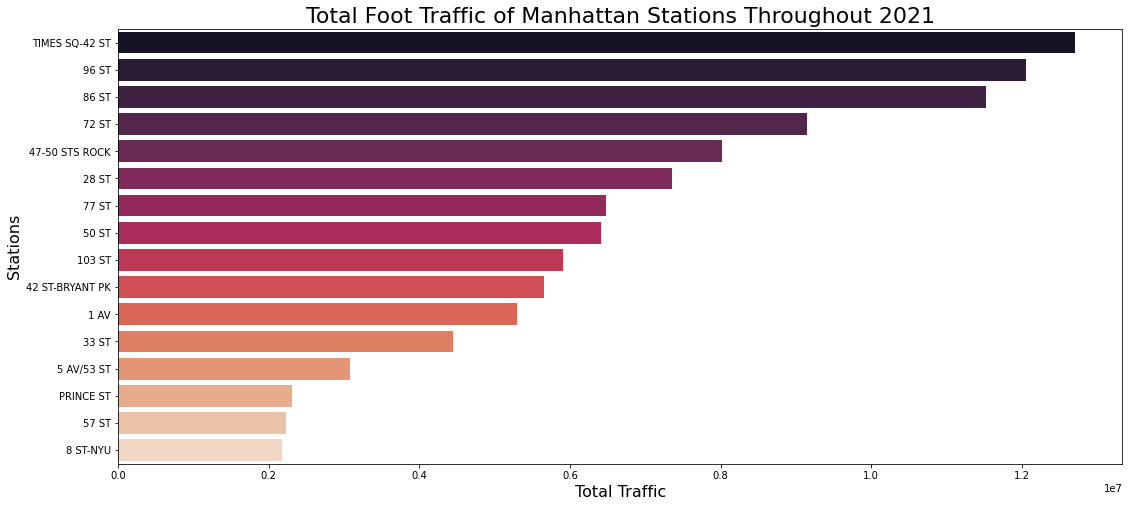

In [170]:
sorted_stn_total = stn_total.sort_values(by=['DAILY_TRAFFIC'], ascending=False)
plt.figure(figsize=(18,8))
c_map = plt.get_cmap('inferno')
sns.barplot(y=sorted_stn_total['STATION'], x=sorted_stn_total['DAILY_TRAFFIC'], palette='rocket', orient='h')
plt.ylabel('Stations', fontsize=16)
plt.xlabel('Total Traffic', fontsize=16)
plt.title('Total Foot Traffic of Manhattan Stations Throughout 2021', fontsize=22);
plt.savefig('top_stations.png', transparent=True, bbox_inches='tight')

In [171]:
def short_mil(num):
    return str(round(num/1000000, 2))+' M'

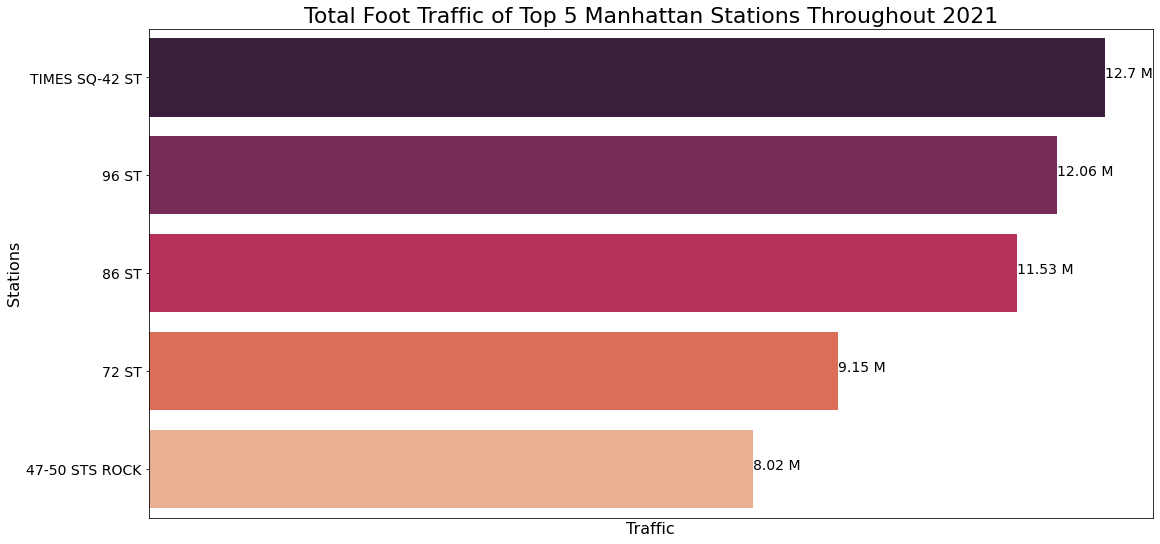

In [172]:
sorted_stn_total = stn_total.sort_values(by=['DAILY_TRAFFIC'], ascending=False)
plt.figure(figsize=(18, 9))
sns.barplot(y=sorted_stn_total['STATION'][:5], x=sorted_stn_total['DAILY_TRAFFIC'][:5], palette='rocket', orient='h')
plt.yticks(fontsize=14)
plt.xticks([])
plt.ylabel('Stations', fontsize=16)
plt.xlabel('Traffic', fontsize=16)
plt.title('Total Foot Traffic of Top 5 Manhattan Stations Throughout 2021', fontsize=22);

for index, value in enumerate(sorted_stn_total['DAILY_TRAFFIC'][:5]):
    plt.text(value, index, short_mil(value), fontsize=14)
    
plt.savefig('top_5_stations.png', transparent=True, bbox_inches='tight')

In [173]:
top_5_stations = ['TIMES SQ-42 ST', '96 ST', '86 ST', '72 ST', '47-50 STS ROCK']

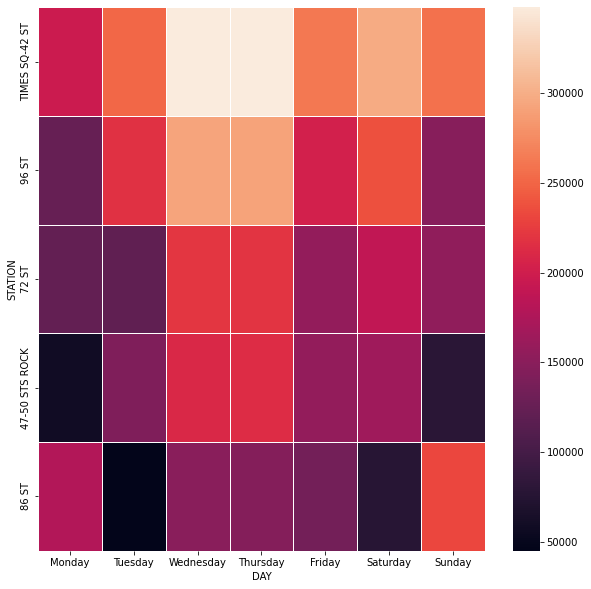

In [174]:
mask = ((stn_daily_traffic['DATE'] > pd.to_datetime('08/31/2021', format='%m/%d/%Y')) &
       (stn_daily_traffic['DATE'] < pd.to_datetime('10/01/2021', format='%m/%d/%Y')) &
       (stn_daily_traffic['STATION'].isin(top_5_stations)))

df = stn_daily_traffic[mask]

station_day = df.groupby(['STATION','DAY'])['DAILY_TRAFFIC'].sum()
group_station = df.groupby(['STATION'])['DAILY_TRAFFIC'].sum().sort_values(ascending=False)

traffic_station_day = station_day.unstack()
traffic_station_day.reset_index()
traffic_station_day = traffic_station_day.reindex(columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
traffic_station_day = traffic_station_day.reindex(index=list(group_station.head(10).index))
traffic_station_day

fig2 = plt.figure(figsize=[10,10])
ax2 = sns.heatmap(traffic_station_day, linecolor='white', linewidths=1)
plt.savefig('heatmap.png', transparent=True, bbox_inches='tight')

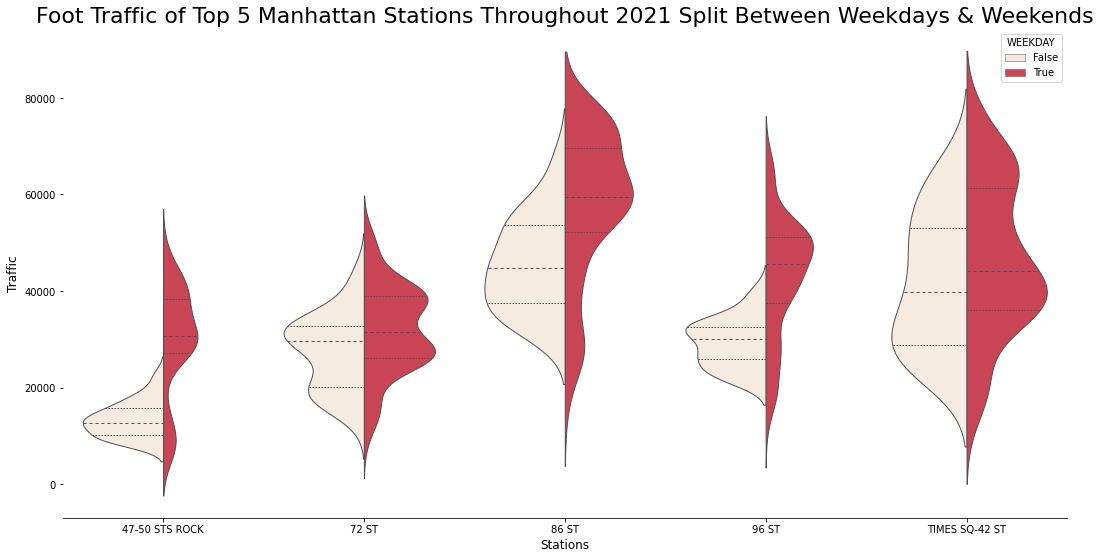

In [191]:
plt.figure(figsize=(18, 9))
sns.violinplot(data=stn_daily_traffic[stn_daily_traffic['STATION'].isin(top_5_stations)], x="STATION", y="DAILY_TRAFFIC", hue="WEEKDAY",
               split=True, inner="quart", linewidth=1,
               palette={True: "#DF2F44", False: "#FAEBDD"})
sns.despine(left=True)
plt.xlabel('Stations', fontsize=12)
plt.ylabel('Traffic', fontsize=12)
plt.title('Foot Traffic of Top 5 Manhattan Stations Throughout 2021 Split Between Weekdays & Weekends', fontsize=22);

plt.savefig('weekdays_weekends.png', transparent=True, bbox_inches='tight')